In [2]:
import pandas as pd

In [676]:
import sys
!{sys.executable} -m pip install --user xgboost

    100% |████████████████████████████████| 1.7MB 9.5MB/s eta 0:00:01
You are using pip version 19.0.3, however version 22.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [16]:
pdfs = !ls -1 dataset_1/pdfs

In [17]:
len(pdfs)

1106

In [266]:
enimies=['Австралия',  
'Албания', 
'Андорра', 
'Великобритания', 
'Джерси', 
'о. Ангилья', 
'Британские Виргинские острова', 
'Гибралтар', 
'Европейский союз', 
'Австрия', 
'Бельгия', 
'Болгария', 
'Венгрия', 
'Германия', 
'Греция', 
'Дания', 
'Ирландия', 
'Испания', 
'Италия', 
'Республика Кипр', 
'Латвия', 
'Литва', 
'Люксембург', 
'Мальта', 
'Нидерланды', 
'Польша', 
'Португалия', 
'Румыния', 
'Словакия', 
'Словения', 
'Финляндия', 
'Франция', 
'Хорватия', 
'Чехия', 
'Швеция', 
'Эстония', 
'Исландия', 
'Канада', 
'Лихтенштейн', 
'Микронезия', 
'Монако', 
'Новая Зеландия', 
'Норвегия', 
'Республика Корея', 
'Сан-Марино', 
'Северная Македония', 
'Сингапур', 
'Соединённые Штаты Америки', 
'Тайвань', 
'Украина', 
'Черногория', 
'Швейцария', 
'Япония']

In [359]:
import pdfplumber
import json
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import pandas as pd
from tqdm.notebook import tqdm as tqdm

# Вычленяем текст из PDF документов #

In [ ]:
stemmer = SnowballStemmer("russian") 

In [370]:
corpus = {}
all_words = []

for file_name in tqdm(pdfs):
    s = ''
    with pdfplumber.open(f"dataset_1/pdfs/{file_name}") as pdf:
        chars = []
        for page in pdf.pages:
            chars.extend([c['text'] for c in page.chars])
        s = ''.join(chars )
        words = [ [stemmer.stem((w.lower()) ) for w in word_tokenize(t) if w.lower() not in stopwords.words('russian') ] for t in sent_tokenize(s)]
        all_words.extend(words)
        corpus[file_name] = words

## Строим пространственные вложения для документов используя текст полученный из PDF

In [371]:
model = Word2Vec(sentences=all_words, vector_size=100, window=2, min_count=5, workers=4)

In [372]:
model.train(all_words, total_examples=model.corpus_count, epochs=80)

(116236751, 158174480)

In [546]:
files_w2v = {}
for file, sentences in corpus.items():
    ws = []
    for sentence in sentences:
        for word in sentence:
            if word in model.wv.key_to_index:
                ws.append(word)

    if len(ws) > 0:
        files_w2v[file] = np.mean([model.wv[word] for word in ws], axis=1)

## Строим пространственные вложения используя названия СИ ##

In [647]:
name_corpus = main_df[main_df['Наименование_СИ'].notna()]['Наименование_СИ'].apply(lambda x: [stemmer.stem(w.lower()) for w in x.split()] )

In [649]:
name_corpus

0                                              [проектор]
1                       [термометр, манометрическ, газов]
2                                  [дифманометр, сильфон]
3              [дефектоскоп, ультразвуков, восьмиканальн]
4                                             [вольтметр]
                               ...                       
100418                           [устройств, пробоотборн]
100419                       [анализатор, состоян, машин]
100420                                   [преобразовател]
100422                                       [анализатор]
100424    [резервуар, горизонтальн, стальн, (траншейные)]
Name: Наименование_СИ, Length: 99851, dtype: object

In [650]:
name_model = Word2Vec(sentences=name_corpus, vector_size=50, window=2, min_count=1, workers=10)

In [651]:
name_model.train(name_corpus, total_examples=name_model.corpus_count, epochs=80)

(29301032, 40719360)

In [680]:
main_df['w2v_name'] = main_df['Наименование_СИ'].apply(lambda x: np.sum((name_model.wv[i] for i in ([stemmer.stem(w.lower()) for w in x.split()]) if i in name_model.wv), axis=1) if type(x)==str else None )

/Users/aponom/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


In [86]:
# w2v.get_vector('дом_NOUN', norm=True)
# [[w2v[word] for word in sentence if word in w2v] for sentence in words]

# Обратываем 2-ю базу # 

In [183]:
csvs = !ls -1 dataset_2

In [184]:
import random
indexes = random.sample(range(0, len(csvs)), 10)

In [185]:
dfs = [ ]
for index in indexes:
    file = csvs[index]
# for file in csvs:
    print(file, end='')
    try:
        df = pd.read_csv(f'dataset_2/{file}', encoding="cp1251", delimiter=";")
        dfs.append(df)
        print('...ok')
    except (RuntimeError, UnicodeDecodeError):
        print('...error')

328 AoEqMi0xNTI2ODk2Mg==.csv...ok
271 AoErMi0xMjcwMzkwODU=.csv...ok
043 AoEqMS0yMzU4ODU4NA==.csv...ok
242 AoErMi0xMTM5ODkwNzc=.csv...ok
037 AoEpMS0yMDg3ODMz.csv...ok
483 AoEqMi01OTI1NTczNA==.csv

/Users/aponom/Library/Python/3.7/lib/python/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


...ok
286 AoErMi0xMzM3ODkxODc=.csv...ok
506 AoEqMi02OTYwNTczNA==.csv...ok
446 AoEqMi00MjYwNTczMg==.csv

/Users/aponom/Library/Python/3.7/lib/python/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


...ok
178 AoEqMS04NTA4NDk3Ng==.csv...ok


In [186]:
df = pd.concat(dfs)

In [187]:
df['Наименование_СИ'].describe()

count                                   4235917
unique                                     9572
top       Счетчики холодной воды и горячей воды
freq                                     233111
Name: Наименование_СИ, dtype: object

In [188]:
df['Модификация_СИ'].describe()

count        4078660
unique         94365
top       нет данных
freq          777700
Name: Модификация_СИ, dtype: object

In [189]:
df['Номер_в_госреестре'].describe()

count      4416207
unique       28464
top       16078-13
freq        230495
Name: Номер_в_госреестре, dtype: object

In [190]:
df['Производитель_СИ'].describe()

count                                               4235887
unique                                                 8231
top       АО "Электротехнические заводы "Энергомера", г....
freq                                                 321510
Name: Производитель_СИ, dtype: object

In [72]:
df

,Номер_в_госреестре,Наименование_СИ,Единица_измерения_СИ,Модификация_СИ,Тип_СИ,Погрешность_СИ,Дата_утверждения_типа_СИ,Производитель_СИ,Дата_поверки_СИ,Наименование_файла_с_описанием,Единица_измерения_Си
0,10297-85,Преобразователи измерительные взрывозащищенные,NaN,Сапфир-22 ДД-Ех,NaN,NaN,NaN,"АООТ ""Теплоприбор"", г.Рязань",11.05.2017 6:00,NaN,NaN
1,43902-14,"Манометры избыточного давления, вакуумметры и ...",NaN,МП4-Уф,NaN,NaN,NaN,"ЗАО ""ПО Физтех"", г.Томск",11.05.2017 6:00,2014-43902-14.pdf,NaN
2,43902-14,"Манометры избыточного давления, вакуумметры и ...",NaN,МП3-Уф,NaN,NaN,NaN,"ЗАО ""ПО Физтех"", г.Томск",11.05.2017 6:00,2014-43902-14.pdf,NaN
3,43902-14,"Манометры избыточного давления, вакуумметры и ...",NaN,МП3-Уф,NaN,NaN,NaN,"ЗАО ""ПО Физтех"", г.Томск",11.05.2017 6:00,2014-43902-14.pdf,NaN
4,22192-01,Трансформаторы тока,NaN,нет данных,NaN,NaN,NaN,"ОАО ""Свердловский завод трансформаторов тока"" ...",28.12.2011 8:00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
499670,24411-12,Счетчики ватт-часов активной энергии переменно...,NaN,Меркурий 201.7,Меркурий 201,NaN,NaN,"ООО ""НПК ""Инкотекс"", г.Москва",2021-07-02T00:00:00Z,2017-24411-12.pdf,NaN
499671,24411-12,Счетчики ватт-часов активной энергии переменно...,NaN,Меркурий 201.7,Меркурий 201,NaN,NaN,"ООО ""НПК ""Инкотекс"", г.Москва",2021-07-06T00:00:00Z,2017-24411-12.pdf,NaN
499672,24411-12,Счетчики ватт-часов активной энергии переменно...,NaN,Меркурий 201.7,Меркурий 201,NaN,NaN,"ООО ""НПК ""Инкотекс"", г.Москва",2021-07-14T00:00:00Z,2017-24411-12.pdf,NaN
499673,24410-18,Счетчики ватт-часов активной энергии переменно...,NaN,Меркурий 200.02,Меркурий 200,NaN,NaN,"ООО ""НПК ""Инкотекс"", г.Москва",2021-07-07T00:00:00Z,2018-24410-18.pdf,NaN


## Загрузка pretrained модели - не используется

In [180]:
# w2v = gensim.models.KeyedVectors.load_word2vec_format('182/model.bin', binary=True)
# w2v = gensim.models.KeyedVectors.load_word2vec_format('182/model.txt', binary=False)
# w2v.vector_size
# w2v.key_to_index

## Считаем данные о категориях ##

In [626]:
data = json.load(open('category_data_3.json'))

categories_dicts = []
for level1 in list(data.keys()):        
    for level2 in list(data[level1]['categories'].keys()):
        for level3 in list(data[level1]['categories'][level2]['subcategories'].keys()):
#             print(f'{level1}/{level2}/{level3}')
            if 'ids' not in data[level1]['categories'][level2]['subcategories'][level3]:
                print('!!!No ids!!!')
                continue
            for i in list(data[level1]['categories'][level2]['subcategories'][level3]['ids'].keys()):
                item = data[level1]['categories'][level2]['subcategories'][level3]['ids'][i]
                categories_dicts.append({'level1':level1, 
                                         'level2':level2,
                                         'level3':level3,
                                         'id':i,
                                         'Класс СИ': item['Класс СИ'],
                                         'Год регистрации': item['Год регистрации'],
                                         'Страна-производитель': item['Страна-производитель'] })

categories = pd.DataFrame(categories_dicts)
categories['Страна-производитель'] = categories['Страна-производитель'].apply(lambda x: x.replace('\xa0',''))

len(categories)

4811

In [606]:
categories['Страна-производитель'].unique()

array(['Россия', 'СССР', 'Украина', 'Германия', 'Литва', 'Япония',
       'Швейцария', 'Молдова', 'Беларусь', 'США', 'Великобритания',
       'Франция', 'Швеция', 'Эстония', 'Армения', 'Азербайджан',
       'Казахстан', 'Канада', 'Польша', 'Австралия', 'Корея', 'Латвия',
       'Финляндия', 'Нидерланды', 'Италия', 'Австрия', 'Грузия', 'Дания',
       'Словакия', 'Чехия', 'Венгрия', 'Киргизия', 'Узбекистан',
       'Нидерланды, США', 'Франция, США', 'США, Германия', 'Италия, США',
       'Болгария', 'Чехословакия', 'Китай', 'Малайзия', 'Ирландия, США',
       'Германия, Швейцария', 'Норвегия', 'Югославия', 'Израиль',
       'Ирландия', 'Новая Зеландия'], dtype=object)

In [607]:
categories.describe()

,level1,level2,level3,id,Класс СИ,Год регистрации,Страна-производитель
count,4811,4811,4811,4811,4811,4811,4811
unique,20,122,675,4802,60,68,48
top,Электрические измерения,СИ ЭДС и напряжения,Прочие документы,15865-96,27.01,1983,Россия
freq,490,94,102,2,524,506,1951


# Объединим коллективно добытые данные #

In [509]:
# загрузим первую базу. будем считать её основной
main_df = pd.read_excel('dataset_ir_13.xlsx', engine='openpyxl')

In [510]:
# нас интересуют только СИ для которых есть текстовое описание
print(len(main_df))
# main_df = main_df[main_df['Наименование_файла_с_описанием'].notna()]
print(len(main_df))

100425
100425


In [511]:
df_gos_id = set(df['Номер_в_госреестре'].values)

In [512]:
categories_god_id = set(categories.id.values)

In [513]:
main_df_gos_id = set(main_df['Номер_в_госреестре'].values)

In [514]:
len(main_df_gos_id), len(categories_god_id), len(df_gos_id), len(df_gos_id.intersection(categories_god_id)), len(main_df_gos_id.intersection(categories_god_id) )

(92235, 2331, 28465, 713, 2280)

In [681]:
merged = main_df.merge(categories, how='inner', left_on='Номер_в_госреестре', right_on='id')

In [682]:
merged['enemy'] = merged['Страна-производитель'].apply(lambda x: x in enimies)

In [683]:
len(merged)

5070

In [684]:
merged.sample(30)

,Номер_в_госреестре,Наименование_СИ,Единица_измерения_СИ,Погрешность_СИ,Наименование_файла_с_описанием,w2v_name,level1,level2,level3,id,Класс СИ,Год регистрации,Страна-производитель,enemy
3370,12799-91,Датчики скорости и направления движения воздуха,NaN,NaN,NaN,"[-9.711125, 3.2801805, -0.3904903, 2.0242925, ...","Измерения расхода, вместимости, уровня, параме...",СИ параметров открытых потоков,Средства поверки СИ параметров потоков газов,12799-91,28.03,1991,Украина,True
3857,29711-05,Рабочий эталон единицы средней мощности в воло...,NaN,NaN,NaN,"[-12.885809, 4.133195, 2.6104074, -15.268736, ...",Измерения в системах связи,СИ характеристик средств волоконно-оптической ...,Средства поверки СИ параметров ВОСП специальные,29711-05,37,2005,Россия,False
233,3385-74,Ротаметры с местными показаниями,NaN,NaN,NaN,"[3.7338495, 2.7205539, -5.1397767, -4.4735785,...","Измерения расхода, вместимости, уровня, параме...",СИ расхода газа,Ротаметры,3385-74,29.01.01.01,1997,Россия,False
1134,17084-98,Трансформаторы тока,NaN,NaN,NaN,"[-4.9025335, 5.9637694, -0.79795974, 0.5225289...",Электрические измерения,"Преобразователи тока, напряжения, мощности изм...",Трансформаторы тока импортные,17084-98,34.01.01,1998,Чехия,True
1102,16511-97,Приборы вторичные,NaN,NaN,NaN,"[1.5806684, 4.76526, -2.293222, 0.45494545, -3...",Механические измерения,СИ силы,Машины силоизмерительные,16511-97,34.01.05,1997,Германия,True
1544,20447-00,Измерители оптической плотности,NaN,NaN,NaN,"[-7.371441, 2.106987, 6.846701, 3.4432912, 1.4...",СИ медицинского назначения,Приборы функциональной диагностики прочие (по ...,Анализаторы результатов наблюдений,20447-00,39,2007,Россия,False
1586,7869-80,Приборы двухкоординатные измерительные,NaN,NaN,NaN,"[-1.9200543, 5.749115, -2.650353, -3.4808624, ...",Геометрические измерения,"Приборы оптико-механические, комплексы измерит...",Машины и приборы координатные,7869-80,27.01,1986,СССР,False
4246,6398-77,Наборы делящихся комплектов нейтронных,NaN,NaN,NaN,"[-2.7574844, 6.385695, 4.5992727, -6.978489, 0...",Измерения параметров ионизирующих излучений и ...,Источники ионизирующих излучений,Источники нейтронов,6398-77,38.01,1977,Россия,False
827,10382-86,Станки балансировочные,NaN,NaN,NaN,"[4.85271, 0.60803795, 0.39683753, 0.6857699, -...",СИ характеристик средств транспорта,СИ характеристик состояния автотранспорта,Балансировка колес автомобиля (см. также 2838),10382-86,28.05,1986,Германия,True
1571,1107-57,Мегомметры,NaN,NaN,NaN,"[-0.20819965, 0.76838744, 0.86173874, 0.099870...",Электрические измерения,СИ параметров цепей с сосредоточенными постоян...,"Мегаомметры, СИ сопротивления изоляции",1107-57,34.02,1963,СССР,False


In [255]:
import matplotlib.pyplot as plt

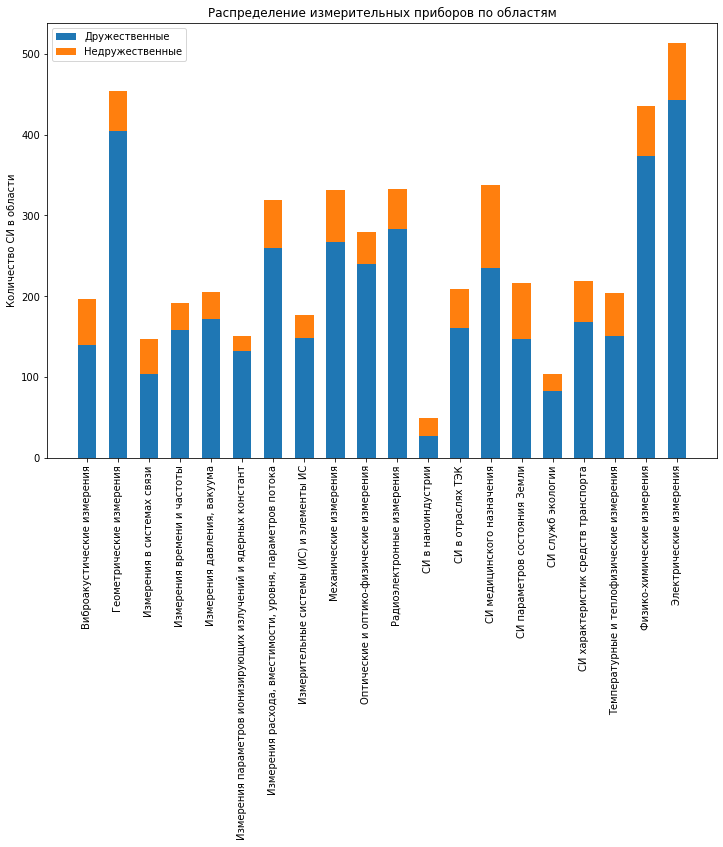

In [631]:
labels = []
friends = []
enemies = []
for area, value in merged.groupby('level1').apply(lambda x: (sum( x.enemy == False), sum(x.enemy)  ) ).to_dict().items():
    labels.append(area)
    friends.append(value[0])
    enemies.append(value[1])

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

width = 0.6       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
# figure(figsize=(80, 60), dpi=80)
fig.set_size_inches(12, 8, forward=True)

ax.bar(labels, friends, width, label='Дружественные')
ax.bar(labels, enemies, width, bottom=friends, label='Недружественные')

ax.set_ylabel('Количество СИ в области')
ax.set_title('Распределение измерительных приборов по областям')
plt.xticks(rotation = 90)
ax.legend()

plt.show()
fig.savefig('Level1 - Распределение типов измерительных приборов по областям.png', dpi=100,transparent=True, bbox_inches='tight')

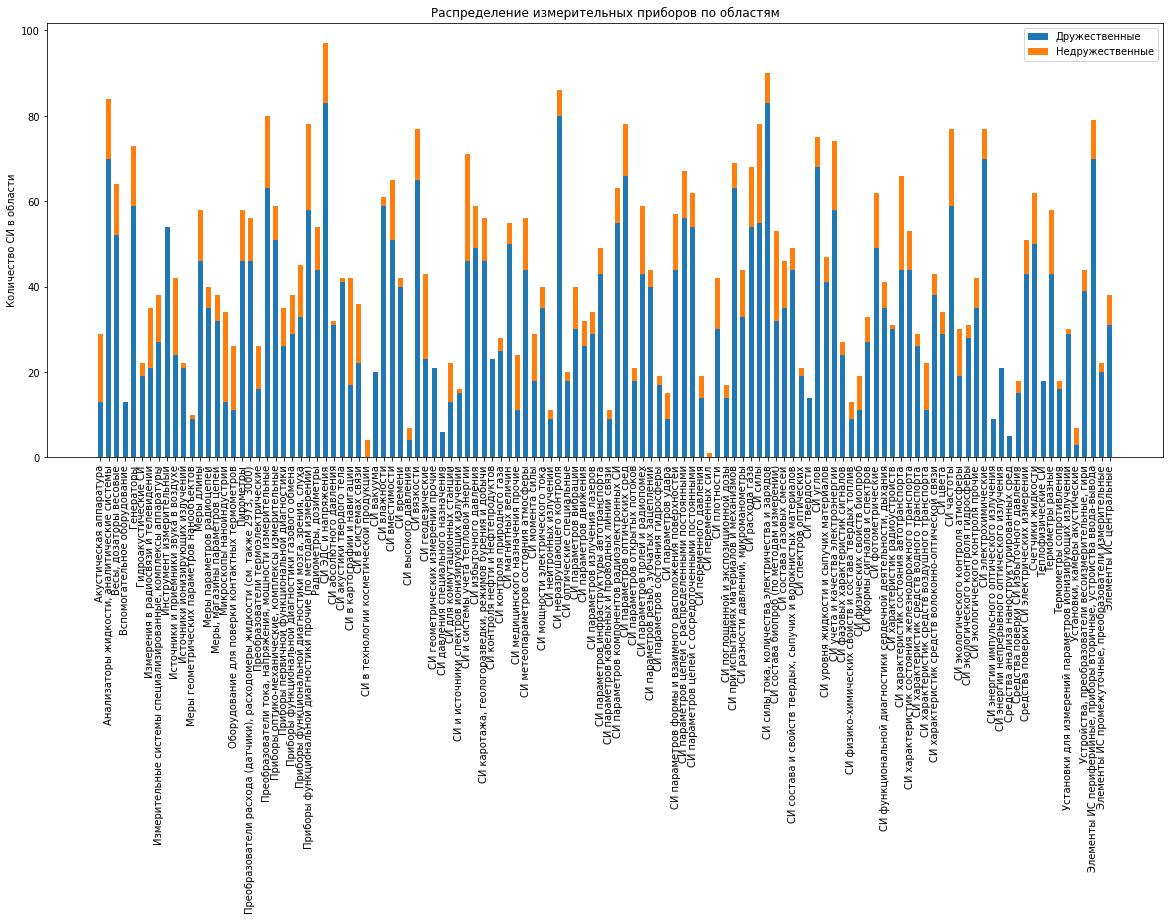

In [632]:
labels = []
friends = []
enemies = []
for area, value in merged.groupby('level2').apply(lambda x: (sum( x.enemy == False), sum(x.enemy)  ) ).to_dict().items():
    labels.append(area)
    friends.append(value[0])
    enemies.append(value[1])

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

width = 0.6       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
fig.set_size_inches(20, 8, forward=True)

ax.bar(labels, friends, width, label='Дружественные')
ax.bar(labels, enemies, width, bottom=friends, label='Недружественные')

ax.set_ylabel('Количество СИ в области')
ax.set_title('Распределение измерительных приборов по областям')
plt.xticks(rotation = 90)
ax.legend()

plt.show()
fig.savefig('Level2 - Распределение типов измерительных приборов по областям.png', dpi=100,transparent=True, bbox_inches='tight')

In [633]:
# merged.groupby('Страна-производитель').apply(lambda x: (sum( x.enemy == False), sum(x.enemy)  ) )
sizes = []
labels = []
for name, size in merged.groupby('Страна-производитель').size().items():
    labels.append(name)
    sizes.append(size)

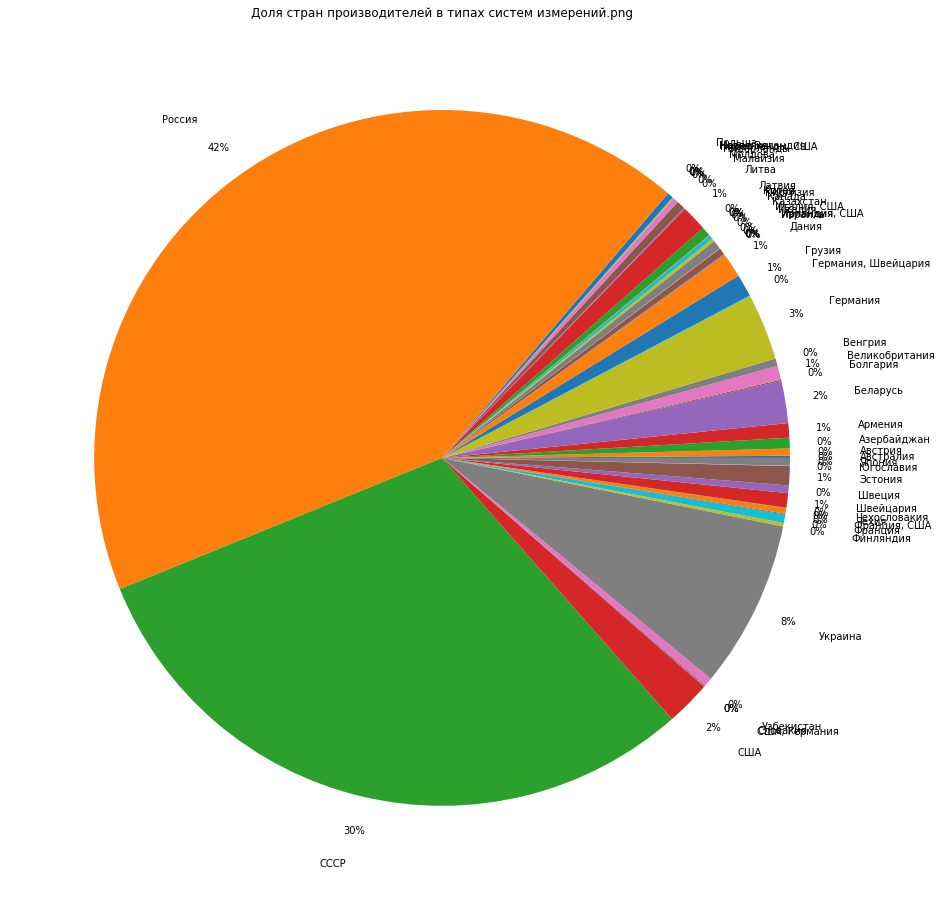

In [634]:
fig, ax = plt.subplots()
fig.set_size_inches(30, 16, forward=True)
ax.set_title('Доля стран производителей в типах систем измерений.png')
plt.pie(sizes, labels=labels, autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
fig.patch.set_facecolor('white')
fig.savefig('Доля стран производителей в типах систем измерений.png', dpi=100, bbox_inches='tight')
plt.show()

In [458]:
merged.sample(30)

,Номер_в_госреестре,Наименование_СИ,Единица_измерения_СИ,Погрешность_СИ,Наименование_файла_с_описанием,level1,level2,level3,id,Класс СИ,Год регистрации,Страна-производитель,enemy
38,7353-79,Приборы,NaN,NaN,NaN,Измерения в системах связи,СИ в системах связи,Меры геометрических параметров нанообъектов,7353-79,35.01,1990,СССР,False
552,17085-98,Трансформаторы тока,NaN,NaN,NaN,Электрические измерения,"Преобразователи тока, напряжения, мощности изм...",Средства анализа наноструктурированных сред,17085-98,34.01.01,2008,Чехия,True
1055,2507-69,Частотомеры электронно-счетные,NaN,NaN,NaN,Измерения времени и частоты,СИ частоты,Средства анализа наноструктурированных сред,2507-69,33.03,1981,Украина,True
1735,2085-65,Линии измерительные,NaN,NaN,NaN,Радиоэлектронные измерения,СИ параметров цепей с распределенными постоянными,Меры геометрических параметров нанообъектов,2085-65,35.04,1981,СССР,False
919,3912-73,Рейки морские водомерные,NaN,NaN,NaN,СИ параметров состояния Земли,СИ параметров состояния гидросферы,Средства анализа наноструктурированных сред,3912-73,29.02,1973,Грузия,False
1444,15809-96,Источники излучения оптические измерительные,NaN,NaN,NaN,Измерения в системах связи,СИ характеристик средств волоконно-оптической ...,Микроскопы наноиндустрии,15809-96,37,2002,Германия,True
1165,165-49,Амперметры щитовые,NaN,NaN,NaN,Электрические измерения,"СИ силы тока, количества электричества и зарядов",Микроскопы наноиндустрии,165-49,34.01.01,1956,СССР,False
1531,1097-57,Генераторы сигналов,NaN,NaN,NaN,Измерения времени и частоты,Генераторы,Меры геометрических параметров нанообъектов,1097-57,35.03,1963,СССР,False
1232,1350-72,"Манометры грузопоршневые класса 0,05",NaN,NaN,NaN,"Измерения давления, вакуума",Средства поверки СИ избыточного давления,Меры геометрических параметров нанообъектов,1350-72,30,1992,Россия,False
176,6976-79,Установка для контроля динамических параметров...,NaN,NaN,NaN,Радиоэлектронные измерения,СИ параметров компонентов радиоэлектронных СИ,Средства анализа наноструктурированных сред,6976-79,35.06,1986,СССР,False


In [440]:
merged[merged['Наименование_файла_с_описанием'].notna()].apply(lambda x: (x['Наименование_файла_с_описанием'].lower() in files_w2v), axis = 1)

8       False
17      False
45      False
51      False
52      False
        ...  
2433    False
2434    False
2435    False
2451    False
2464    False
Length: 206, dtype: bool

In [488]:
import os

In [547]:
files_w2v = { "-".join(k.split("-")[1:])[:-4].replace("_NoRestriction", ""):v for k,v in files_w2v.items()}

In [637]:
df_ir = pd.read_excel('dataset_ir_13.xlsx', engine='openpyxl')
df_ir = df_ir.rename(columns={
    "Номер_в_госреестре": "N", 
    "Наименование_СИ": "CI",
    "Единица_измерения_СИ": "CI count",
    "Погрешность_СИ": "Error",
    "Наименование_файла_с_описанием": "File",
})

ids = df_ir['N'].values
files = ["-".join(f.split("-")[1:])[:-4].replace("_NoRestriction", "") for f in os.listdir('dataset_1/pdfs')]
print("Всего файлов:", len(files))
print("Совпадают:", len(set(ids).intersection(set(files))))
print("Совпадают:", len(set(ids).intersection(set(files_w2v.keys()))))

Всего файлов: 1106
Совпадают: 1054
Совпадают: 1052


In [639]:
df_ir['w2v'] = df_ir['N'].apply(lambda x: files_w2v[x] if x in files_w2v.keys() else np.NaN )

In [640]:
df_ir[df_ir['w2v'].notna()]

,N,CI,CI count,Error,File,w2v
24,46695-11,Системы весоизмерительные многоплатформенные п...,NaN,"±0,20",2011-46695-11.pdf,"[-0.25380635, -0.24463606, -0.005026036, -0.10..."
32,46750-11,Система автоматизированная информационно-измер...,NaN,"±0,25",2011-46750-11.pdf,"[-0.25380635, -0.24463606, -0.005026036, -0.10..."
123,54447-13,Система автоматизированная информационно-измер...,NaN,NaN,2013-54447-13.pdf,"[-0.10934165, -0.005026036, -0.019531269, -0.1..."
329,49648-12,Датчики силоизмерительные тензорезисторные с д...,NaN,NaN,2012-49648-12.pdf,"[-0.25380635, -0.24463606, -0.005026036, -0.10..."
546,57469-14,Счетчики тепловой энергии ультразвуковые,NaN,NaN,2019-57469-14.pdf,"[-0.25380635, -0.24463606, -0.005026036, -0.10..."
...,...,...,...,...,...,...
98504,79208-20,Уровни строительные,NaN,NaN,2020-79208-20.pdf,"[-0.25380635, -0.24463606, -0.005026036, -0.10..."
98543,79291-20,Твердомеры стационарные Бринелля,NaN,NaN,2020-79291-20.pdf,"[-0.25380635, -0.24463606, -0.005026036, -0.10..."
98604,30815-05,Трансформатор напряжения эталонный мобильный,NaN,NaN,2005-30815-05.pdf,"[-0.2527712, -0.7747126, -0.24442177, -0.06272..."
98954,44940-10,Имитаторы спутниковых навигационных систем,NaN,NaN,2021-44940-10.pdf,"[-0.09483062, 0.046620023, -0.0785691, -0.0402..."


In [559]:
merged['w2v'] = merged['Номер_в_госреестре'].apply(lambda x: files_w2v[x] if x in files_w2v.keys() else None )

In [641]:
len(df_ir), len(merged)

(100425, 5070)

In [557]:
df_ir['w2v'] = df_ir['N'].apply(lambda x: files_w2v[x] if x in files_w2v.keys() else None )

In [577]:
df_ir['CI'].describe()

count                   99851
unique                  40304
top       Трансформаторы тока
freq                     1584
Name: CI, dtype: object

In [635]:
print("Всего файлов:", len(files))
# print("Совпадают:", len(set(ids).intersection(set(files_w2v.keys()))))
print("Совпадают:", len(set(merged['Номер_в_госреестре'].values).intersection(set(files_w2v.keys()))))

Всего файлов: 1106
Совпадают: 1


In [591]:
merged

,Номер_в_госреестре,Наименование_СИ,Единица_измерения_СИ,Погрешность_СИ,Наименование_файла_с_описанием,level1,level2,level3,id,Класс СИ,Год регистрации,Страна-производитель,enemy
0,564-50,Проекторы,NaN,"±0,6",NaN,Геометрические измерения,"Приборы оптико-механические, комплексы измерит...",Средства анализа наноструктурированных сред,564-50,27.01,1974,СССР,False
1,5645-76,Ритмокардиометры,NaN,"±1,5",NaN,СИ медицинского назначения,СИ функциональной диагностики сердечной деятел...,Средства анализа наноструктурированных сред,5645-76,39,1981,Россия,False
2,16712-97,Стенды балансировочные,NaN,NaN,NaN,СИ характеристик средств транспорта,СИ характеристик состояния автотранспорта,Микроскопы наноиндустрии,16712-97,28.05,1997,Италия,True
3,5652-76,Приборы лабораторные полуавтоматические,NaN,NaN,NaN,Механические измерения,СИ при испытаниях материалов и механизмов,Средства анализа наноструктурированных сред,5652-76,28.04,2003,Россия,False
4,26003-03,Станции сбора данных,NaN,NaN,NaN,Измерения параметров ионизирующих излучений и ...,Установки для измерений параметров ионизирующи...,Микроскопы наноиндустрии,26003-03,38.01,2003,Россия,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2465,7610-80,Измерители диаметров нити,NaN,NaN,NaN,Геометрические измерения,СИ геометрических измерений прочие,Меры геометрических параметров нанообъектов,7610-80,27.01,1983,СССР,False
2466,9393-84,Уровни резонансные криогенные,NaN,NaN,NaN,"Измерения расхода, вместимости, уровня, параме...",СИ уровня жидкости и сыпучих материалов,Средства анализа наноструктурированных сред,9393-84,27.01,1984,Россия,False
2467,369-49,Щупы,NaN,NaN,NaN,Геометрические измерения,Меры длины,Микроскопы наноиндустрии,369-49,27.01,1973,СССР,False
2468,8119-81,Системы информационно-измерительные,NaN,NaN,NaN,Электрические измерения,СИ магнитных величин,Микроскопы наноиндустрии,8119-81,34.03,1981,Украина,True


In [594]:
errors = pd.read_excel('1847 (Autosaved).xlsx', engine='openpyxl', header=None)

In [595]:
errors

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,1,Измерения при осуществлении деятельности в обл...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.1.,Измерение температуры тела человека контактным...,от 32 до 42°C вкл.,"± 0,1°C",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.2.,Измерение веса (массы) человека,"от 0,5 до 15 кг вкл.","± 0,01 кг",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.2.,Измерение веса (массы) человека,свыше 15 до 150 кг,"± 0,1 кг",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.3.,Измерение роста человека,от 300 до 2000 мм,± 5 мм,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,12.46.1.2.,В динамическом состоянии (при скорости движени...,"от 0,5 до 2,5 вкл. М свыше 2,5 до 12,5 и свыше м","± 0,1 м",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
747,12.46.1.2.,В динамическом состоянии (при скорости движени...,"от 0,5 до 2,5 вкл. М свыше 2,5 до 12,5 и свыше м",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
748,12.46.2.,На автоматических пунктах весового контроля (п...,"от 0,5 до 30 и свыше м","± 0,03 м",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
749,12.47.,Измерение координат цветности источников света...,"x: от 0,0039 до 0,7347; y: от 0,0048 до 0,8338","± (0,0030 / 0,01)",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
merged2 = merged.merge(Класс СИ)

# Переходим к тренировке модели #

In [685]:
merged

,Номер_в_госреестре,Наименование_СИ,Единица_измерения_СИ,Погрешность_СИ,Наименование_файла_с_описанием,w2v_name,level1,level2,level3,id,Класс СИ,Год регистрации,Страна-производитель,enemy
0,564-50,Проекторы,NaN,"±0,6",NaN,"[0.63025314, 1.1501405, -0.8865392, 0.08389516...",Геометрические измерения,"Приборы оптико-механические, комплексы измерит...",Проекторы,564-50,27.01,1974,СССР,False
1,5645-76,Ритмокардиометры,NaN,"±1,5",NaN,"[0.01642456, 0.016281981, 0.008947687, -0.0150...",СИ медицинского назначения,СИ функциональной диагностики сердечной деятел...,Кардиографы,5645-76,39,1981,Россия,False
2,5647-76,Экспресс-анализаторы на углерод,NaN,±5,NaN,"[-7.2704506, 1.1234682, -0.13709915, 1.3873823...",Физико-химические измерения,"СИ состава и свойств твердых, сыпучих и волокн...",Анализаторы состава и свойств твердых материал...,5647-76,31.01,2000,Беларусь,False
3,16712-97,Стенды балансировочные,NaN,NaN,NaN,"[2.0987325, 2.9900012, -1.1519576, -1.309978, ...",СИ характеристик средств транспорта,СИ характеристик состояния автотранспорта,Балансировка колес автомобиля (см. также 2838),16712-97,28.05,1997,Италия,True
4,5652-76,Приборы лабораторные полуавтоматические,NaN,NaN,NaN,"[2.8560436, 10.132771, -2.4333453, 0.4468614, ...",Механические измерения,СИ при испытаниях материалов и механизмов,"Машины испытательные строительных материалов, ...",5652-76,28.04,2003,Россия,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5065,8525-81,Вибростенды,NaN,NaN,NaN,"[0.13763146, 1.2412902, 1.0030254, -0.27561367...",Виброакустические измерения,СИ параметров вибрации,Стенды. Установки вибрационные,8525-81,28.03,1981,Дания,True
5066,5632-76,Установки для приготовления газовых смесей неп...,NaN,NaN,NaN,"[-11.786794, 19.171457, 3.2436452, -0.30178833...",Физико-химические измерения,СИ состава газовых смесей,"Установки газоаналитические, газосмесительные,...",5632-76,31.01,1977,Россия,False
5067,893-54,Мотовила для пряжи,NaN,NaN,NaN,"[-2.5666807, 2.7345152, -0.08532058, -1.881874...",Механические измерения,СИ при испытаниях материалов и механизмов,"Машины испытательные бумаг, картона, ткани, кож",893-54,28.04,1986,СССР,False
5068,12189-90,Весы,NaN,NaN,NaN,"[-1.614105, 2.9217286, -1.0003875, 1.8872912, ...",Механические измерения,"Весы, дозаторы весовые",Весы торговые импортные,12189-90,28.01,1990,Канада,True


In [686]:
merged

,Номер_в_госреестре,Наименование_СИ,Единица_измерения_СИ,Погрешность_СИ,Наименование_файла_с_описанием,w2v_name,level1,level2,level3,id,Класс СИ,Год регистрации,Страна-производитель,enemy
0,564-50,Проекторы,NaN,"±0,6",NaN,"[0.63025314, 1.1501405, -0.8865392, 0.08389516...",Геометрические измерения,"Приборы оптико-механические, комплексы измерит...",Проекторы,564-50,27.01,1974,СССР,False
1,5645-76,Ритмокардиометры,NaN,"±1,5",NaN,"[0.01642456, 0.016281981, 0.008947687, -0.0150...",СИ медицинского назначения,СИ функциональной диагностики сердечной деятел...,Кардиографы,5645-76,39,1981,Россия,False
2,5647-76,Экспресс-анализаторы на углерод,NaN,±5,NaN,"[-7.2704506, 1.1234682, -0.13709915, 1.3873823...",Физико-химические измерения,"СИ состава и свойств твердых, сыпучих и волокн...",Анализаторы состава и свойств твердых материал...,5647-76,31.01,2000,Беларусь,False
3,16712-97,Стенды балансировочные,NaN,NaN,NaN,"[2.0987325, 2.9900012, -1.1519576, -1.309978, ...",СИ характеристик средств транспорта,СИ характеристик состояния автотранспорта,Балансировка колес автомобиля (см. также 2838),16712-97,28.05,1997,Италия,True
4,5652-76,Приборы лабораторные полуавтоматические,NaN,NaN,NaN,"[2.8560436, 10.132771, -2.4333453, 0.4468614, ...",Механические измерения,СИ при испытаниях материалов и механизмов,"Машины испытательные строительных материалов, ...",5652-76,28.04,2003,Россия,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5065,8525-81,Вибростенды,NaN,NaN,NaN,"[0.13763146, 1.2412902, 1.0030254, -0.27561367...",Виброакустические измерения,СИ параметров вибрации,Стенды. Установки вибрационные,8525-81,28.03,1981,Дания,True
5066,5632-76,Установки для приготовления газовых смесей неп...,NaN,NaN,NaN,"[-11.786794, 19.171457, 3.2436452, -0.30178833...",Физико-химические измерения,СИ состава газовых смесей,"Установки газоаналитические, газосмесительные,...",5632-76,31.01,1977,Россия,False
5067,893-54,Мотовила для пряжи,NaN,NaN,NaN,"[-2.5666807, 2.7345152, -0.08532058, -1.881874...",Механические измерения,СИ при испытаниях материалов и механизмов,"Машины испытательные бумаг, картона, ткани, кож",893-54,28.04,1986,СССР,False
5068,12189-90,Весы,NaN,NaN,NaN,"[-1.614105, 2.9217286, -1.0003875, 1.8872912, ...",Механические измерения,"Весы, дозаторы весовые",Весы торговые импортные,12189-90,28.01,1990,Канада,True


In [679]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [688]:
xtrain, xtest, ytrain, ytest=train_test_split(merged['w2v_name'], merged['level1'], test_size=0.2)

In [678]:
xg_level1 = XGBClassifier()

In [690]:
# xg_level1.fit(xtrain, ytrain)

# KNN #

In [702]:
from sklearn.neighbors import KNeighborsClassifier

In [722]:
knn_level1 = KNeighborsClassifier(n_neighbors=1)

In [723]:
knn_level1.fit( list(xtrain.values), list(ytrain.values) )

KNeighborsClassifier(n_neighbors=1)

In [724]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [725]:
ytest_pred = knn_level1.predict(list(xtest) )
print(f"Train accuracy: {knn_level1.score(list(xtrain), list(ytrain))}, test accuracy: {knn_level1.score( list(xtest) ,list(ytest))}" )

Train accuracy: 0.9694280078895463, test accuracy: 0.6745562130177515


In [726]:
print(classification_report(ytest, ytest_pred))

                                                                precision    recall  f1-score   support

                                   Виброакустические измерения       0.55      0.52      0.54        42
                                      Геометрические измерения       0.61      0.80      0.69        93
                                    Измерения в системах связи       0.63      0.61      0.62        31
                                   Измерения времени и частоты       0.72      0.78      0.75        37
                                   Измерения давления, вакуума       0.79      0.70      0.75        44
Измерения параметров ионизирующих излучений и ядерных констант       0.72      0.66      0.69        35
     Измерения расхода, вместимости, уровня, параметров потока       0.82      0.73      0.77        67
                      Измерительные системы (ИС) и элементы ИС       0.65      0.46      0.54        48
                                        Механические измерения 

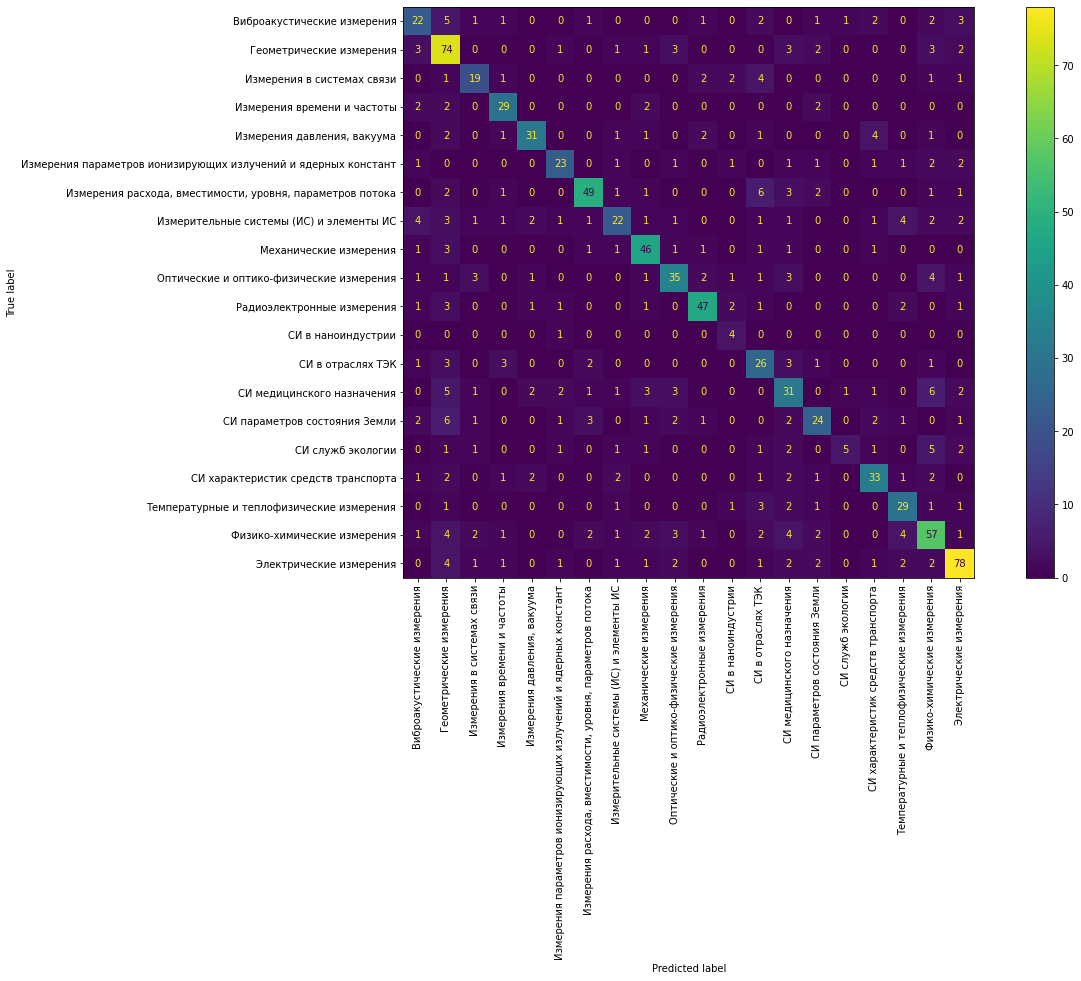

In [738]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm = confusion_matrix( ytest, ytest_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(merged['level1'].values) )
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot(include_values=True, xticks_rotation=90)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
# fig.savefig('test2png.png', dpi=100)
plt.show()